In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn.plotting as nil
import glob
from lito_radiomics.lito_radiomics.lito_features import shape2D
import os
import cupy as cp
from cupyx.scipy import ndimage
import math
import radiomics
from radiomics import featureextractor
from math import isclose
import SimpleITK as sitk
from scipy import spatial
import scipy
import datatable as dt
from sklearn.preprocessing import StandardScaler
from skimage.measure import EllipseModel, find_contours
from skimage.metrics import hausdorff_distance
from skimage.draw import ellipse
from sklearn.calibration import LabelEncoder
from nibabel.affines import apply_affine
import random
import ipympl
%matplotlib widget
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
with open('/mnt/data/psteinmetz/neotex/CSV/slices_thresholded20_filled_resized.pickle', 'rb') as handle:
    axial_cuts_data = pickle.load(handle)

/tmp/ipykernel_3662189/171244952.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True).dropna(axis=1)


array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

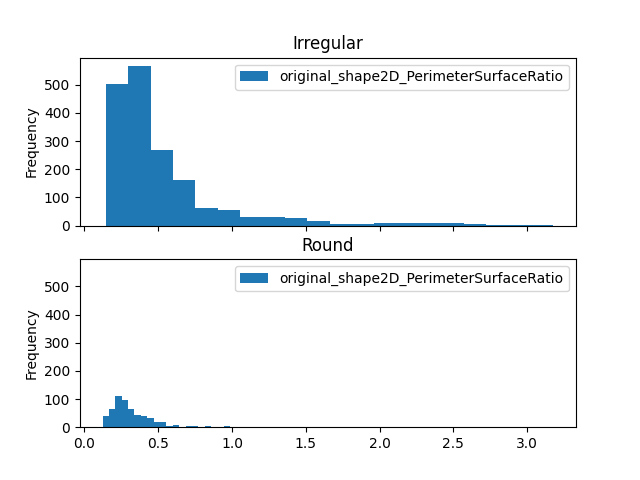

In [3]:
plt.close('all')
path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/"
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Bounding_box_ville.csv'

data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True).dropna(axis=1)
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)

list_cases = os.listdir(path_data)

shape_modified = shape_target_train.replace('Oval', 'Round')
big_size_cuts = {k:v[v['original_shape2D_MeshSurface'] >= v['original_shape2D_MeshSurface'].quantile(0.25)] for (k,v) in axial_cuts_data.items()}
big_size_cuts = {k:v.assign(Shape=shape_modified['Shape.1'][shape_modified['Record_ID'] == int(k)].iloc[0]) for (k,v) in big_size_cuts.items()}

to_plot = pd.concat(big_size_cuts, axis=0)
to_plot['original_shape2D_PerimeterSurfaceRatio'] = to_plot['original_shape2D_PerimeterSurfaceRatio'].astype(float)

order_list_psratio = to_plot.groupby(level=0)['original_shape2D_PerimeterSurfaceRatio'].median().sort_values().index
order_list_sphericity = to_plot.groupby(level=0)['original_shape2D_Sphericity'].median().sort_values().index
order_list_ellipticity = to_plot.groupby(level=0)['ellipticity'].median().sort_values().index
order_list_dice = to_plot.groupby(level=0)['Dice'].median().sort_values().index
order_list_residuals = to_plot.groupby(level=0)['Residuals'].median().sort_values().index
order_list_haussdorff = to_plot.groupby(level=0)['Haussdorff'].median().sort_values().index

to_plot.plot.hist(column='original_shape2D_PerimeterSurfaceRatio', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

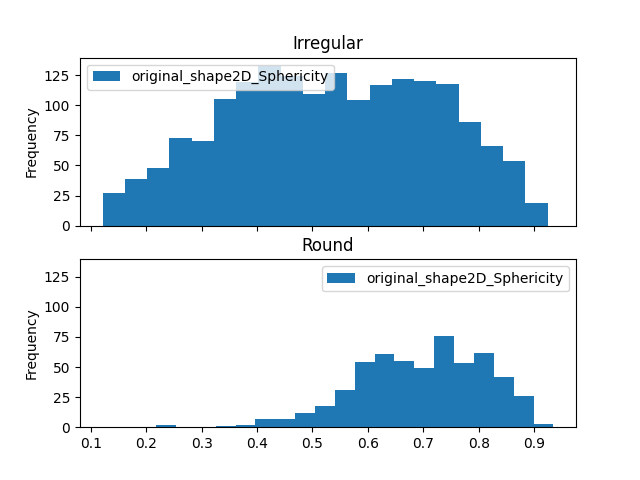

In [4]:
to_plot.plot.hist(column='original_shape2D_Sphericity', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

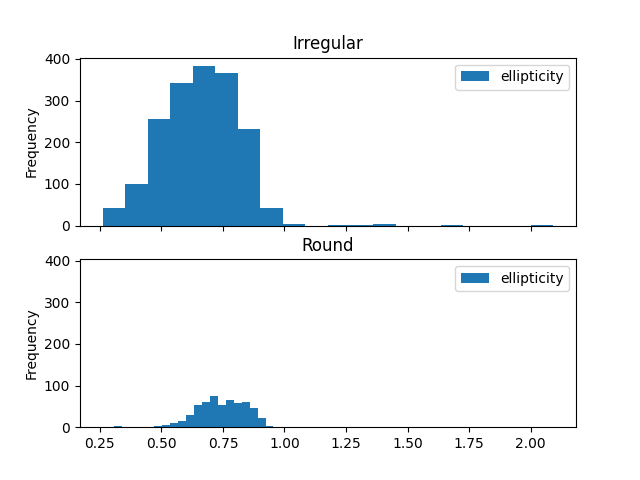

In [5]:
to_plot.plot.hist(column='ellipticity', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

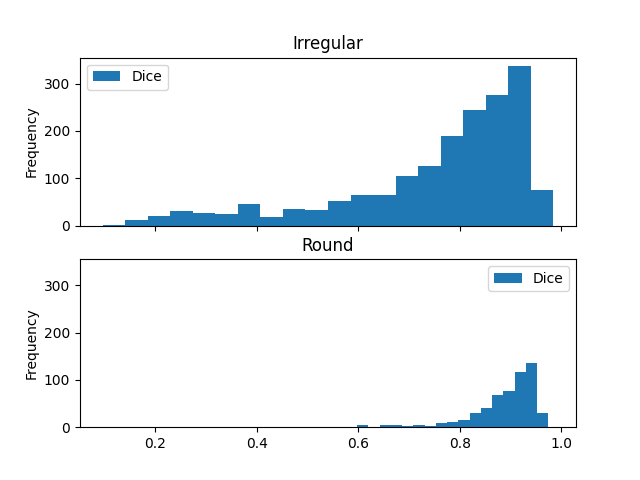

In [7]:
to_plot.plot.hist(column='Dice', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

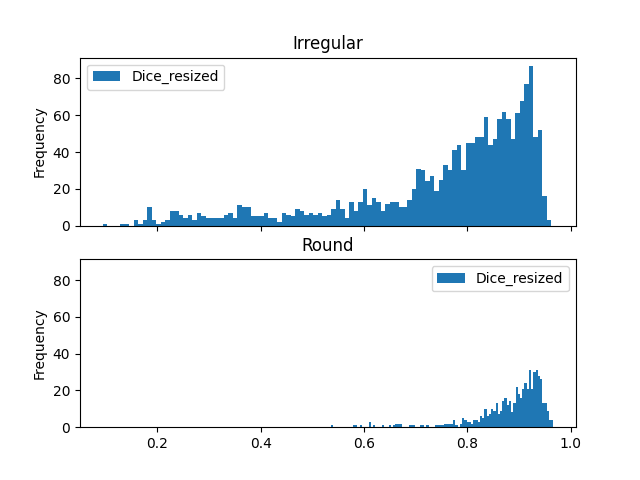

In [45]:
to_plot.plot.hist(column='Dice_resized', by="Shape", sharex=True, sharey=True, bins=100)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

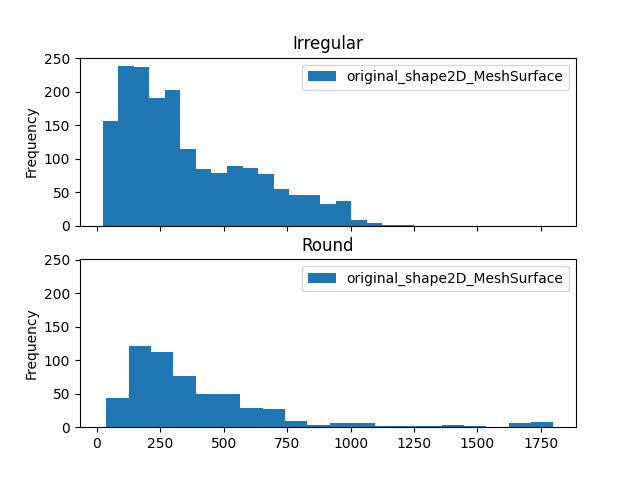

In [9]:
to_plot.plot.hist(column='original_shape2D_MeshSurface', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

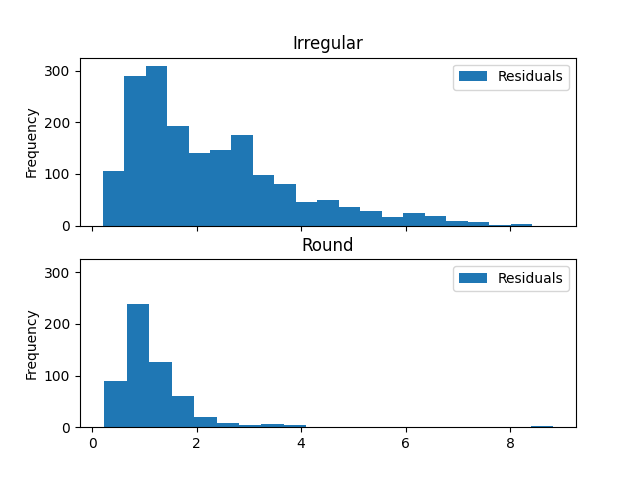

In [10]:
to_plot.plot.hist(column='Residuals', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

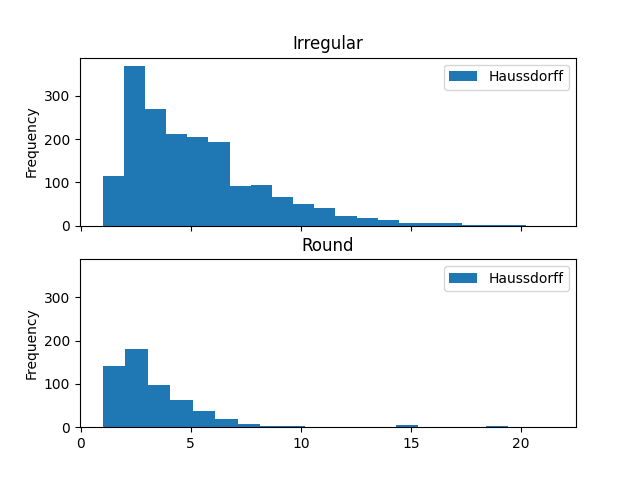

In [11]:
to_plot.plot.hist(column='Haussdorff', by="Shape", sharex=True, sharey=True, bins=20)

In [12]:
le = LabelEncoder()
le.fit_transform(to_plot['Shape'])

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
amb = 1477
irreg = 1632
round = 1203
arr = pd.DataFrame([[irreg, amb, round]], columns=['Irregular', 'Ambiguous', 'Round'])


<Axes: >

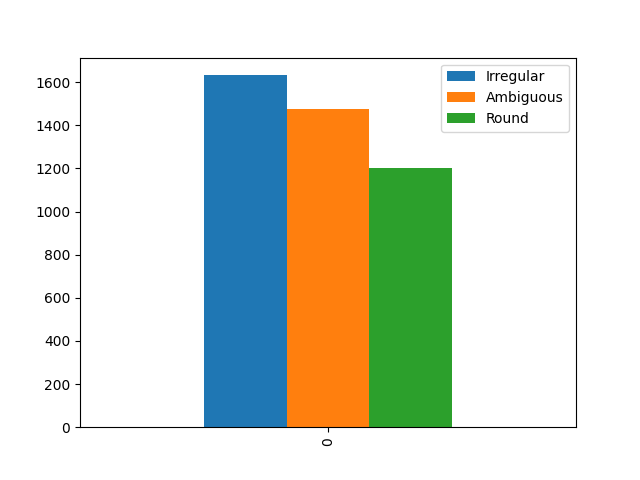

In [13]:
arr.plot.bar()

<Axes: xlabel='original_shape2D_Sphericity', ylabel='original_shape2D_PerimeterSurfaceRatio'>

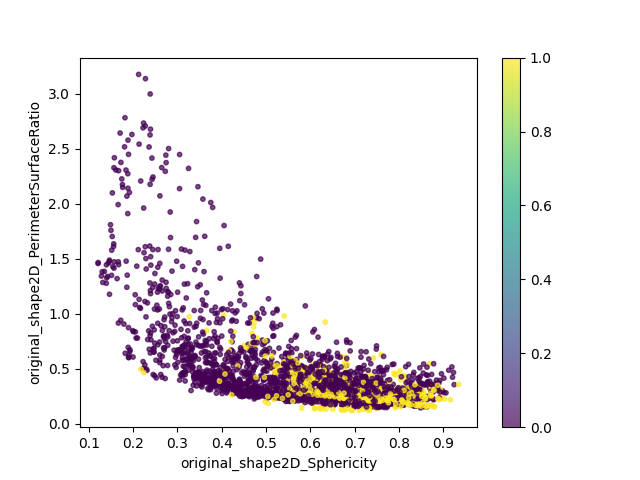

In [13]:
le = LabelEncoder()
le.fit(to_plot['Shape'])
to_plot.plot.scatter(x='original_shape2D_Sphericity', y='original_shape2D_PerimeterSurfaceRatio', c=le.fit_transform(to_plot['Shape']), colormap='viridis', alpha=0.7, s=10)

<Axes: xlabel='ellipticity', ylabel='Dice'>

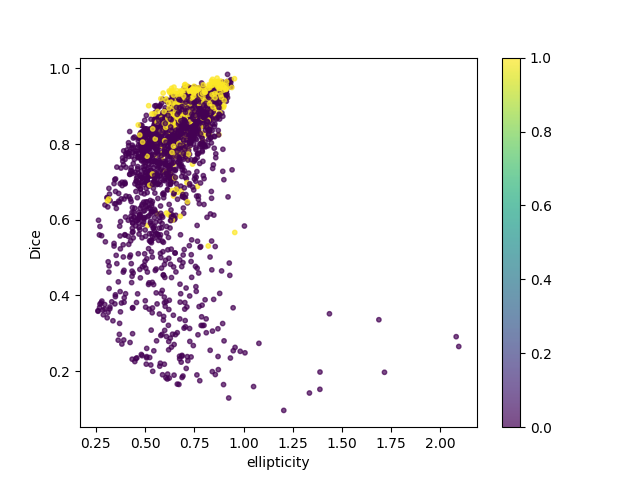

In [14]:
le = LabelEncoder()
le.fit(to_plot['Shape'])
to_plot.plot.scatter(x='ellipticity', y='Dice', c=le.fit_transform(to_plot['Shape']), colormap='viridis', alpha=0.7, s=10)

/tmp/ipykernel_140880/2465468769.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=to_plot, x='original_shape2D_Sphericity', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])


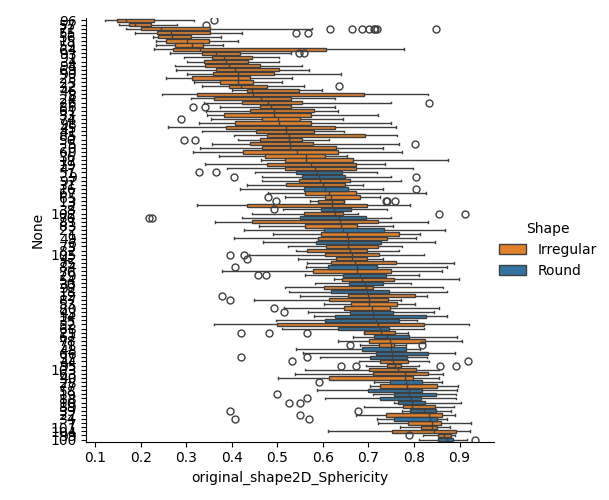

In [15]:
to_plot.sort_values(by='Shape', inplace=True)
to_plot = to_plot.reindex(order_list_sphericity, level=0)
sns.catplot(data=to_plot, x='original_shape2D_Sphericity', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])

/tmp/ipykernel_140880/909205675.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=to_plot, x='ellipticity', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])


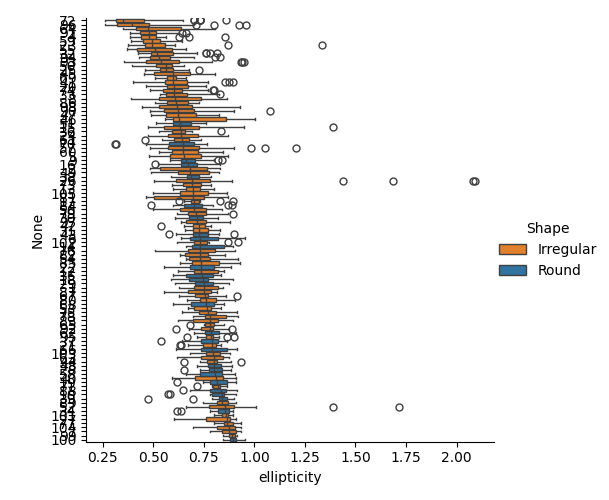

In [16]:
to_plot = to_plot.reindex(order_list_ellipticity, level=0)
sns.catplot(data=to_plot, x='ellipticity', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])

/tmp/ipykernel_140880/638674004.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=to_plot, x='original_shape2D_PerimeterSurfaceRatio', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])


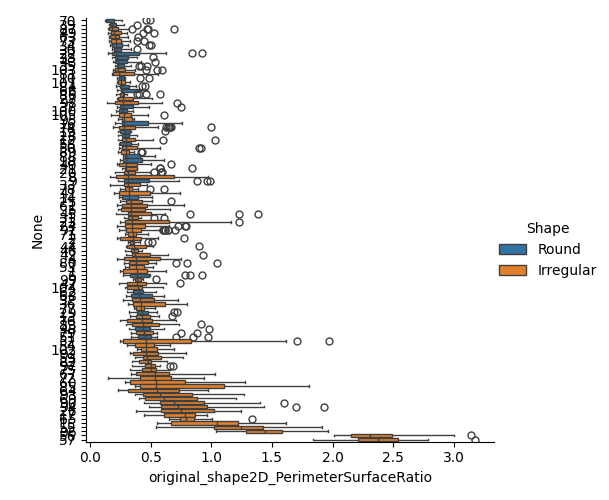

In [17]:
to_plot = to_plot.reindex(order_list_psratio, level=0)
sns.catplot(data=to_plot, x='original_shape2D_PerimeterSurfaceRatio', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])

/tmp/ipykernel_140880/550764395.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=to_plot, x='Dice', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])


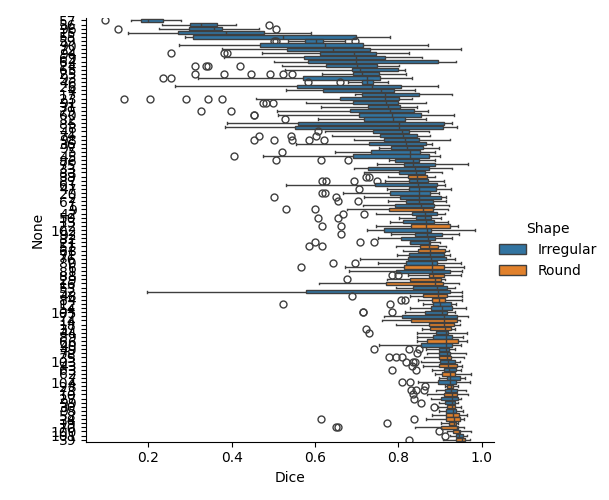

In [18]:
plt.close('all')
to_plot = to_plot.reindex(order_list_dice, level=0)
sns.catplot(data=to_plot, x='Dice', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])

/tmp/ipykernel_140880/3522524415.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=to_plot, x='Residuals', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])


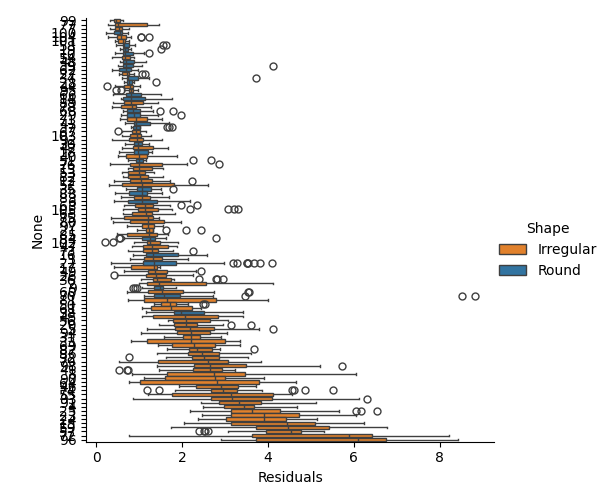

In [20]:
to_plot = to_plot.reindex(order_list_residuals, level=0)
sns.catplot(data=to_plot, x='Residuals', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])

/tmp/ipykernel_140880/343578183.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=to_plot, x='Haussdorff', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])


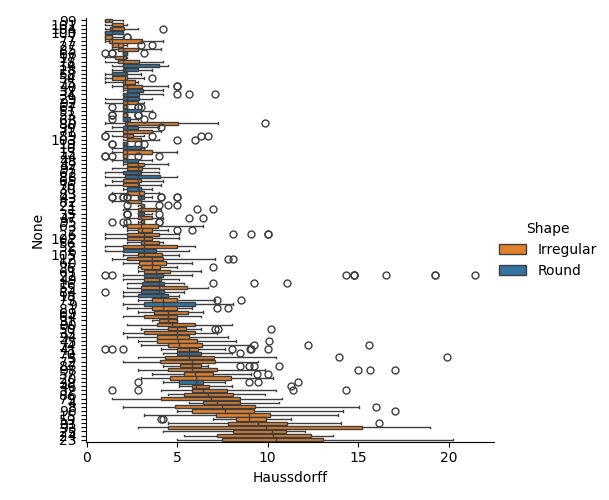

In [21]:
to_plot = to_plot.reindex(order_list_haussdorff, level=0)
sns.catplot(data=to_plot, x='Haussdorff', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])

In [25]:
round_cuts = to_plot.loc[to_plot['Dice']>0.9]
ambiguous_cuts = to_plot.loc[to_plot['Dice'].between(0.8, 0.9)]
irreg_cuts = to_plot.loc[to_plot['Dice']<0.8]

In [26]:
to_plot["Axial cut cat"] = np.nan
to_plot.loc[to_plot['Dice']>0.9, "Axial cut cat"] = "Round_cuts"
to_plot.loc[to_plot['Dice'].between(0.8, 0.9), "Axial cut cat"] = "Ambiguous_cuts"
to_plot.loc[to_plot['Dice']<0.8, "Axial cut cat"] = "Irregular_cuts"

/tmp/ipykernel_140880/4228957814.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Round_cuts' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  to_plot.loc[to_plot['Dice']>0.9, "Axial cut cat"] = "Round_cuts"


In [29]:
to_plot["Axial cut cat resized"] = np.nan
to_plot.loc[to_plot['Dice_resized']>0.9, "Axial cut cat resized"] = "Round_cuts"
to_plot.loc[to_plot['Dice_resized'].between(0.8, 0.9), "Axial cut cat resized"] = "Ambiguous_cuts"
to_plot.loc[to_plot['Dice_resized']<0.8, "Axial cut cat resized"] = "Irregular_cuts"

/tmp/ipykernel_140880/293413191.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Round_cuts' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  to_plot.loc[to_plot['Dice_resized']>0.9, "Axial cut cat resized"] = "Round_cuts"


In [39]:
to_plot.shape

(2341, 11)

In [40]:
858+780+703

2341

In [43]:
to_plot

ellipticity  original_shape2D_PerimeterSurfaceRatio  \
99 11     0.875107                                0.429920   
   10     0.887913                                0.387964   
   9      0.905279                                0.372292   
   8      0.905331                                0.368764   
   7      0.844771                                0.385134   
...            ...                                     ...   
23 24     0.496218                                0.350020   
   10     0.398246                                0.690436   
   9      0.439273                                0.914444   
   7      0.594173                                1.160849   
   8      0.560640                                0.964392   

       original_shape2D_Sphericity  Residuals      Dice  Dice_resized  \
99 11                     0.848207   0.497454  0.896907      0.900232   
   10                     0.869225   0.396057  0.937500      0.934783   
   9                      0.889854   0.323829  0.943723      0.938144   
   8                      0.883075   0.459954  0.933333      0.925175   
   7                      0.819988   0.631671  0.911197      0.906687   
...                            ...        ...       ...           ...   
23 24                     0.414327   3.095060  0.762784      0.766968   
   10                     0.268926   4.973734  0.559177      0.548532   
   9                      0.255892   5.798432  0.459161      0.456553   
   7                      0.278186   4.781958  0.344311      0.337705   
   8                      0.287910   5.465967  0.377407      0.376698   

       Haussdorff  original_shape2D_MeshSurface      Shape   Axial cut cat  \
99 11    1.000000                          94.5  Irregular  Ambiguous_cuts   
   10    1.000000                         110.5  Irregular      Round_cuts   
   9     1.000000                         114.5  Irregular      Round_cuts   
   8     1.414214                         118.5  Irregular      Round_cuts   
   7     2.000000                         126.0  Irregular      Round_cuts   
...           ...                           ...        ...             ...   
23 24    8.246211                         597.5  Irregular  Irregular_cuts   
   10    9.000000                         364.5  Irregular  Irregular_cuts   
   9     7.211103                         229.5  Irregular  Irregular_cuts   
   7     9.899495                         120.5  Irregular  Irregular_cuts   
   8     8.485281                         163.0  Irregular  Irregular_cuts   

      Axial cut cat resized  
99 11            Round_cuts  
   10            Round_cuts  
   9             Round_cuts  
   8             Round_cuts  
   7             Round_cuts  
...                     ...  
23 24        Irregular_cuts  
   10        Irregular_cuts  
   9         Irregular_cuts  
   7         Irregular_cuts  
   8         Irregular_cuts  

[2341 rows x 11 columns]

In [35]:
to_plot["Axial cut cat"].value_counts()

Axial cut cat
Irregular_cuts    858
Ambiguous_cuts    780
Round_cuts        703
Name: count, dtype: int64

In [33]:
to_plot["Axial cut cat resized"].value_counts()

Axial cut cat resized
Irregular_cuts    876
Ambiguous_cuts    805
Round_cuts        660
Name: count, dtype: int64

array([<Axes: title={'center': 'Ambiguous_cuts'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Irregular_cuts'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round_cuts'}, ylabel='Frequency'>],
      dtype=object)

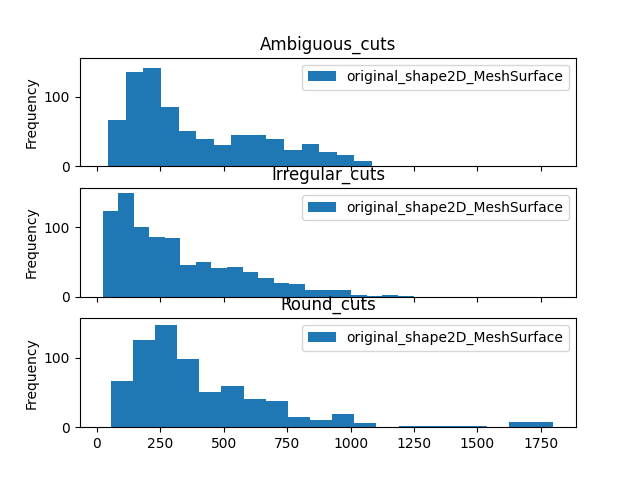

In [28]:
to_plot.plot.hist(column='original_shape2D_MeshSurface', by="Axial cut cat", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Ambiguous_cuts'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Irregular_cuts'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round_cuts'}, ylabel='Frequency'>],
      dtype=object)

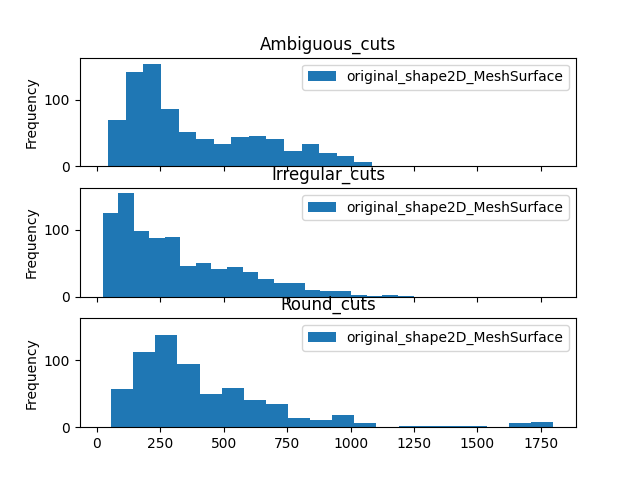

In [30]:
to_plot.plot.hist(column='original_shape2D_MeshSurface', by="Axial cut cat resized", sharex=True, sharey=True, bins=20)

In [41]:
def compute_dice_ellipse(a, b, eigen_vect, mask_slice):
    
    angle1 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0])
    angle2 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0]) + np.deg2rad(90)

    center = ndimage.center_of_mass(cp.asarray(sitk.GetArrayFromImage(mask_slice)))
    xy1 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle1))
    xy2 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle2))
    ell1 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle1)
    ell2 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle2)

    contours = find_contours(sitk.GetArrayFromImage(mask_slice), 0.5)
    contours = [np.flip(contours[k]) for k in range(len(contours))]

    ellipse_estimation = EllipseModel()
    if ellipse_estimation.estimate(xy1):
        residuals1 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
        
    if ellipse_estimation.estimate(xy2):
        residuals2 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
        
    shape_slice = sitk.GetArrayFromImage(mask_slice).shape
    mask_ellipse1 = np.zeros(shape_slice)
    mask_ellipse1[[i for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    mask_ellipse2 = np.zeros(shape_slice)
    mask_ellipse2[[i for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    dice1=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse1.ravel())
    dice2=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse2.ravel())
    hauss1 = hausdorff_distance(sitk.GetArrayFromImage(mask_slice), mask_ellipse1)
    hauss2 = hausdorff_distance(sitk.GetArrayFromImage(mask_slice), mask_ellipse2)
    if dice1 >= dice2:
        return residuals1, dice1, hauss1, xy1, mask_ellipse1, center
    else:
        return residuals2, dice2, hauss2, xy2, mask_ellipse2, center

In [42]:
def standardize_roi(image, mask, desired_area):

    # Calculate the current area of the ROI
    current_area = cp.sum(mask)
    print(f'area {str(current_area)}')
    
    if current_area > 5:
        # Calculate the scaling factor
        scale_factor = cp.sqrt(desired_area / current_area)
        print(f'mask scaling factor {str(scale_factor)}')

        return ndimage.zoom(cp.array(image), scale_factor), ndimage.zoom(cp.array(mask), scale_factor, order=0)
    else:
        return None, None


In [43]:
def _extracted_from_features_extraction2D_4(arg0, cut, data_spacing):
    result = sitk.GetImageFromArray(arg0[int(cut), :, :])
    result.SetSpacing(
        (
            float(data_spacing[0]),
            float(data_spacing[1]),
            float(data_spacing[2]),
        )
    )
    result = sitk.JoinSeries(result)

    return result

In [44]:
def _extracted_from_features_extraction2D_11():
    result = featureextractor.RadiomicsFeatureExtractor(force2D=True)
    result.disableAllFeatures()
    result.enableFeaturesByName(
        shape2D=[
            "PerimeterSurfaceRatio",
            "Sphericity",
            "MajorAxisLength",
            "MinorAxisLength",
            "Perimeter",
            "MeshSurface"
        ]
    )

    return result

In [45]:
def ellipse_perimeter(a, b):
    """
    Compute the perimeter of an ellipse using Ramanujan's approximation formula.
    
    Parameters:
        a (float): Length of the semi-major axis.
        b (float): Length of the semi-minor axis.
    
    Returns:
        float: Perimeter of the ellipse.
    """
    h = ((a - b) / (a + b))**2
    return np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))

In [46]:
def for_ellipse_creation(features_extractor, image, mask):
    results = features_extractor.execute(image, mask)
    features_lito = shape2D.LitoRadiomicsShape2D(image, mask)
    features_eigenvect = features_lito.getEigenVectorsFeatureValue()
    
    a = float(results['original_shape2D_MajorAxisLength'])/2  # Semi-major axis
    b = float(results['original_shape2D_MinorAxisLength'])/2  # Semi-minor axis
    perimeter = ellipse_perimeter(a, b)
    real_perimeter = float(results['original_shape2D_Perimeter'])
    ellipticity = perimeter/real_perimeter
    
    return results, features_eigenvect, a, b, ellipticity

In [47]:
def fill_holes(mask):
    return scipy.ndimage.binary_fill_holes(mask[0, :, :]).astype(float)

In [48]:
def features_extraction2D(image, mask, cut, filled=True):
    
    data_spacing = [1,1,1]
    sitk_img = _extracted_from_features_extraction2D_4(image, cut, data_spacing)
    sitk_mask = _extracted_from_features_extraction2D_4(mask, cut, data_spacing)
    sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)
    
    if filled is True:
        sitk_mask = sitk.GetImageFromArray(fill_holes(sitk.GetArrayFromImage(sitk_mask)))
    
    resized_image, resized_mask = standardize_roi(sitk.GetArrayFromImage(sitk_img), sitk.GetArrayFromImage(sitk_mask), 1250)
    try:
        resized_image = sitk.GetImageFromArray(cp.asnumpy(resized_image))
        resized_mask = sitk.GetImageFromArray(cp.asnumpy(resized_mask))
        features_40_slice_resized = _extracted_from_features_extraction2D_11()

        features_40_slice = _extracted_from_features_extraction2D_11()

        image = sitk_img[:, :, 0] if filled is True else sitk_img
        resized_image = resized_image[:, :, 0] if filled is True else resized_image
        results, features_eigenvect, a, b, ellipticity = for_ellipse_creation(features_40_slice, image, sitk_mask)
        results_resized, features_eigenvect_resized, a_resized, b_resized, _ = for_ellipse_creation(features_40_slice_resized, resized_image, resized_mask)

        res, di, hauss, cont_ellipse, mask_ell, center = compute_dice_ellipse(a, b, features_eigenvect, sitk_mask)
        _, di_resized, _, _, _, _ = compute_dice_ellipse(a_resized, b_resized, features_eigenvect_resized, resized_mask)
        
        return ellipticity, float(results['original_shape2D_PerimeterSurfaceRatio']), float(results['original_shape2D_Sphericity']), res, di, di_resized, hauss, float(results['original_shape2D_MeshSurface'])
    except (ValueError, TypeError):
        return None, None, None, None, None, None, None, None

In [49]:
def resegment_thresholding(image, mask, thresh=0.2):
    
    max = (image*mask).max()
    print(thresh*max)
    new_mask20= np.ma.masked_where((image*mask) > thresh*max, mask)

    return new_mask20.mask.astype(float)

In [50]:
def remove_out_of_box_mask(mask, box):
    _, y, z = np.where(~box.mask)
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max()
    
    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)


    mask[:, :y_min_iso, :] = mask[:, y_max_iso+1:, :] = mask[:, :, :z_min_iso] = mask[:, :, z_max_iso+1:] = 0
    
    return mask
    

In [51]:
def add_random_rotation(im, gamma, alpha, beta):

    cos_gamma = np.cos(gamma)
    sin_gamma = np.sin(gamma)

    
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)

    
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    
    rotation_affine_gamma = np.array([[cos_gamma, -sin_gamma, 0, 0],
                                      [sin_gamma, cos_gamma, 0, 0],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])
    
    rotation_affine_alpha = np.array([[cos_alpha, 0, sin_alpha, 0],
                                      [0, 1, 0, 0],
                                      [-sin_alpha, 0, cos_alpha, 0],
                                      [0, 0, 0, 1]])
    rotation_affine_beta = np.array([[1, 0, 0, 0],
                                     [0, cos_beta, -sin_beta, 0],
                                     [0, sin_beta, cos_beta, 0],
                                     [0, 0, 0, 1]])
    
    rotated_data_ax = ndimage.rotate(cp.array(im.dataobj), np.rad2deg(gamma), axes=(1, 2), reshape=True)#False)
    rotated_data_ax_cor = ndimage.rotate(rotated_data_ax, np.rad2deg(alpha), axes=(0, 2), reshape=True)#False)
    rotated_data_ax_cor_sag = ndimage.rotate(rotated_data_ax_cor, np.rad2deg(beta), axes=(0, 1), reshape=True)#False)
    im_affine_ax = im.affine.dot(rotation_affine_gamma)
    im_affine_ax_sag = im_affine_ax.dot(rotation_affine_alpha)
    im_affine_ax_sag_cor = im_affine_ax_sag.dot(rotation_affine_beta)

    return rotated_data_ax_cor_sag, im_affine_ax_sag_cor

In [52]:
def check_orientation(ct_image, ct_arr):
    """
    Check the NIfTI orientation, and flip to  'RPS' if needed.
    :param ct_image: NIfTI file
    :param ct_arr: array file
    :return: array after flipping
    """
    x, y, z = nib.aff2axcodes(ct_image.affine)
    
    if x != 'R':
        ct_arr = np.rot90(ct_arr, axes=(0,2), k=1)
    if y != 'P':
        ct_arr = np.flip(ct_arr, axis=1)
    if z != 'S':
        ct_arr = np.flip(ct_arr, axis=2)
    
    return ct_arr

In [53]:
def check_registration(im1, im2):
    ax, az=im1.header['qoffset_x'], im1.header['qoffset_z']
    bx, bz=im2.header['qoffset_x'], im2.header['qoffset_z']

    return bool(
        math.isclose(az, bz, rel_tol=0.05)
        and math.isclose(ax, bx, rel_tol=0.05)
    )

In [54]:
def rescale_to_255(array):
    """
    Rescale the values of a 2D NumPy array to the range [0, 255].
    
    Parameters:
        array (numpy.ndarray): Input 2D array.
        
    Returns:
        numpy.ndarray: Rescaled array with values in the range [0, 255].
    """
    min_val = np.min(array)
    max_val = np.max(array)

    # Ensure the array is not constant to avoid division by zero
    if min_val != max_val:
        scaled_array = 255 * (array - min_val) / (max_val - min_val)
    else:
        scaled_array = array

    return scaled_array.astype(np.uint8)

In [55]:
def add_random_rotation(im, gamma, alpha, beta):

    cos_gamma = np.cos(gamma)
    sin_gamma = np.sin(gamma)

    
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)

    
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    
    rotation_affine_gamma = np.array([[cos_gamma, -sin_gamma, 0, 0],
                                      [sin_gamma, cos_gamma, 0, 0],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])
    
    rotation_affine_alpha = np.array([[cos_alpha, 0, sin_alpha, 0],
                                      [0, 1, 0, 0],
                                      [-sin_alpha, 0, cos_alpha, 0],
                                      [0, 0, 0, 1]])
    rotation_affine_beta = np.array([[1, 0, 0, 0],
                                     [0, cos_beta, -sin_beta, 0],
                                     [0, sin_beta, cos_beta, 0],
                                     [0, 0, 0, 1]])
    
    rotated_data_ax = ndimage.rotate(cp.array(im.dataobj), np.rad2deg(gamma), axes=(1, 2), reshape=True)#False)
    rotated_data_ax_cor = ndimage.rotate(rotated_data_ax, np.rad2deg(alpha), axes=(0, 2), reshape=True)#False)
    rotated_data_ax_cor_sag = ndimage.rotate(rotated_data_ax_cor, np.rad2deg(beta), axes=(0, 1), reshape=True)#False)
    im_affine_ax = im.affine.dot(rotation_affine_gamma)
    im_affine_ax_sag = im_affine_ax.dot(rotation_affine_alpha)
    im_affine_ax_sag_cor = im_affine_ax_sag.dot(rotation_affine_beta)

    return rotated_data_ax_cor_sag, im_affine_ax_sag_cor

In [59]:
path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/"
list_cases = os.listdir(path_data)
all_slices = {}
with cp.cuda.Device(1):
    for case in list_cases:
        if '.' not in case:
            print(case)
            path_data = f"/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/{str(case)}"

            if case!='39':
                image_path_sub = glob.glob(
                    f'{path_data}/RawVolume/*substracted*_Bspline_zscore_without_tumour.nii.gz'
                )
                image_path_dyn = glob.glob(
                    f'{path_data}/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz'
                )
            else:
                print('here')
                image_path_sub = glob.glob(
                    f'{path_data}/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz'
                )
            mask_bb_path = glob.glob(f'{path_data}/RoiVolume/Bounding_box.nii.gz')
            if case == '72':
                mask_path = glob.glob('/mnt/data/psteinmetz/C1_volume_resampled_NN.uint16.nii.gz')
            else:
                mask_path = glob.glob(f'{path_data}/RoiVolume/C1_volume_resampled_NN.nii.gz')
            print(path_data)

            mask_bb = nib.load(mask_bb_path[0])
            mask = nib.load(mask_path[0])
            if case!='39':
                image_sub = nib.load(image_path_sub[0])
                image_dyn = nib.load(image_path_dyn[0])
                x = check_registration(image_sub, image_dyn)
                image = image_sub if x is True else image_dyn
            else:
                image = nib.load(image_path_sub[0])
            a_im_rescaled = nib.Nifti1Image(rescale_to_255(check_orientation(image, np.array(image.dataobj))), affine=image.affine)
            a_im = nib.Nifti1Image(check_orientation(image, np.array(image.dataobj)), affine=image.affine)
            a_ma = check_orientation(mask, np.array(mask.dataobj))
            a_ma[a_ma > 0.1] = 1
            a_ma[a_ma <=0.1] = 0
            a_ma = nib.Nifti1Image(a_ma, affine=mask.affine)
            a_ma_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
            a_ma_bb = nib.Nifti1Image(np.ma.masked_where(a_ma_bb>0.1, a_ma_bb), affine=mask_bb.affine)
            
            gamma = 0
            alpha = 0
            beta = 0

            a_im_rotated, rotated_affine = add_random_rotation(a_im, gamma, alpha, beta)
            a_ma_rotated, ma_rotated_affine = add_random_rotation(a_ma, gamma, alpha, beta)
            a_ma_bb_rotated, ma_bb_rotated_affine = add_random_rotation(a_ma_bb, gamma, alpha, beta)
            a_ma_rotated[a_ma_rotated > 0.1] = 1
            a_ma_rotated[a_ma_rotated <=0.1] = 0
            a_ma_bb_rotated[a_ma_bb_rotated > 0.1] = 1
            a_ma_bb_rotated[a_ma_bb_rotated <=0.1] = 0
            new_image = nib.Nifti1Image(a_im_rotated, affine=rotated_affine)
            original_new_mask = nib.Nifti1Image(a_ma_rotated, affine=ma_rotated_affine)
            new_mask = nib.Nifti1Image(resegment_thresholding(np.array(a_im_rotated.get()), np.array(a_ma_rotated.get())), affine=ma_rotated_affine)
            new_mask_bb = nib.Nifti1Image(a_ma_bb_rotated, affine=ma_bb_rotated_affine)

            final_rot_image = cp.float32(new_image.dataobj.get())
            final_rot_mask = cp.float32(new_mask.dataobj)
            final_rot_mask_orig = cp.float32(original_new_mask.dataobj.get())
            final_rot_mask_bb = cp.float32(new_mask_bb.dataobj.get())
            final_rot_mask = remove_out_of_box_mask(final_rot_mask, np.ma.masked_equal(final_rot_mask_bb, 0))

            inside_bb_rotated = final_rot_mask_bb * final_rot_image
            to_display = np.ma.masked_equal(inside_bb_rotated, 0)

            a = np.argwhere(final_rot_mask_bb==1)[:, 0]
            center_ax_cuts = np.median(a)

            list_slices = [features_extraction2D(final_rot_image, final_rot_mask, k) for k in np.unique(a) if features_extraction2D(final_rot_image, final_rot_mask, k) is not None]
            
            all_slices[case] = pd.DataFrame(
                list_slices,
                columns=[
                    'ellipticity',
                    'original_shape2D_PerimeterSurfaceRatio',
                    'original_shape2D_Sphericity',
                    'Residuals',
                    'Dice',
                    'Dice_resized',
                    'Haussdorff',
                    'original_shape2D_MeshSurface'
                ],
            )
            
    with open('/mnt/data/psteinmetz/neotex/CSV/slices_thresholded20_filled_resized.pickle', 'wb') as handle:
        pickle.dump(all_slices, handle, protocol=pickle.HIGHEST_PROTOCOL)


7
/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/7
9.014436828158802
area 0.0
area 0.0
area 17.0
mask scaling factor 8.574929257125442
area 17.0
mask scaling factor 8.574929257125442
area 49.0
mask scaling factor 5.050762722761053
area 49.0
mask scaling factor 5.050762722761053
area 84.0
mask scaling factor 3.857583749052298
area 84.0
mask scaling factor 3.857583749052298
area 104.0
mask scaling factor 3.466876226407682
area 104.0
mask scaling factor 3.466876226407682
area 116.0
mask scaling factor 3.282660821493064
area 116.0
mask scaling factor 3.282660821493064
area 134.0
mask scaling factor 3.054236108907631
area 134.0
mask scaling factor 3.054236108907631
area 158.0
mask scaling factor 2.81271975231506
area 158.0
mask scaling factor 2.81271975231506
area 173.0
mask scaling factor 2.688016652852352
area 173.0
mask scaling factor 2.688016652852352
area 183.0
mask scaling factor 2.6135418674465836
area 183.0
mask scaling factor 2.6135418674465836
area 183.0
mask scaling factor 2.6135

KeyboardInterrupt: 

In [60]:
all_slices

{'7':     ellipticity  original_shape2D_PerimeterSurfaceRatio  \
 0           NaN                                     NaN   
 1      0.781983                                1.347272   
 2      0.769202                                0.762280   
 3      0.781976                                0.513583   
 4      0.862435                                0.414203   
 5      0.935426                                0.356824   
 6      0.894474                                0.357292   
 7      0.839907                                0.358901   
 8      0.876110                                0.329681   
 9      0.781540                                0.363980   
 10     0.862322                                0.328445   
 11     0.900073                                0.312946   
 12     0.909390                                0.320261   
 13     0.932846                                0.327139   
 14     0.922238                                0.355474   
 15     0.835114                   

In [ ]:
np.unique(~box.mask)

In [ ]:
y

In [ ]:
path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/IRM-Ville/"
list_cases = os.listdir(path_data)
all_slices = {}
for case in list_cases:
    if '.' not in case:
        print(case)
        path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/" + str(case)

        if case!='39':
            image_path_sub = glob.glob(path_data + '/RawVolume/*substracted*_Bspline_zscore_without_tumour.nii.gz')
            image_path_dyn = glob.glob(path_data + '/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz')
        else:
            print('here')
            image_path_sub = glob.glob(path_data + '/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz')
        mask_bb_path = glob.glob(path_data + '/RoiVolume/Bounding_box.nii.gz')
        if case == '72':
            mask_path = glob.glob('/mnt/data/psteinmetz/C1_volume_resampled_NN.uint16.nii.gz')
        else:
            mask_path = glob.glob(path_data + '/RoiVolume/C1_volume_resampled_NN.nii.gz')
        print(path_data)

        mask_bb = nib.load(mask_bb_path[0])
        mask = nib.load(mask_path[0])
        if case!='39':
            image_sub = nib.load(image_path_sub[0])
            image_dyn = nib.load(image_path_dyn[0])
            x = check_registration(image_sub, image_dyn)
            if x is True:
                image= image_sub
            else:
                image=image_dyn
        else:
            image = nib.load(image_path_sub[0])
        a_im = nib.Nifti1Image(check_orientation(image, np.array(image.dataobj)), affine=image.affine)
        a_ma = nib.Nifti1Image(check_orientation(mask, np.array(mask.dataobj)), affine=mask.affine)
        a_ma_bb = nib.Nifti1Image(check_orientation(mask_bb, np.array(mask_bb.dataobj)), affine=mask_bb.affine)

        a_ma = nib.Nifti1Image(resegment_thresholding(np.array(a_im.dataobj), np.array(a_ma.dataobj)), affine=a_ma.affine)
        # if case!=39:
        #     a_ma = nib.Nifti1Image(resegment_thresholding(np.array(a_im.dataobj), np.array(a_ma.dataobj)), affine=a_ma.affine)
        # else:
        #     a_ma = nib.Nifti1Image(resegment_thresholding(np.array(a_im.dataobj), np.array(a_ma.dataobj), 0.05), affine=a_ma.affine)

        final_image = np.array(a_im.dataobj)
        final_mask = np.array(a_ma.dataobj)
        final_mask_bb = np.array(a_ma_bb.dataobj)

        inside_bb = final_mask_bb * final_image
        to_display = np.ma.masked_equal(inside_bb, 0)

        a = np.argwhere(final_mask_bb==1)[:, 0]
        center_ax_cuts = np.median(a)

        list_slices = [features_extraction2D(final_image, final_mask, k, to_display) for k in np.unique(a) if features_extraction2D(final_image, final_mask, k, to_display) is not None]
        all_slices.update({case: pd.DataFrame(list_slices, columns=['ellipticity', 'original_shape2D_PerimeterSurfaceRatio', 'original_shape2D_Sphericity', 'Residuals', 'Dice', 'original_shape2D_MeshSurface'])})
with open('/mnt/data/psteinmetz/neotex/CSV/slices_thresholded20_filled_ville.pickle', 'wb') as handle:
    pickle.dump(all_slices, handle, protocol=pickle.HIGHEST_PROTOCOL)
